In [1]:
#Importing libraries
%matplotlib inline
import pytraj as pt
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import time

In [2]:
#Indicating files
prmtop = '../rosetta3_system.prmtop'
trajlist = './rosetta_replicate_unwrapped.nc'
length = 1000 #Length of the trajectory in ns for correct axis in plots
pt_col = 'slateblue'

In [3]:
#Loading files
trajectory = pt.iterload(trajlist, prmtop, stride=1) #Picking 1 frame for each stride
print(trajectory)

pytraj.TrajectoryIterator, 2000 frames: 
Size: 4.404455 (GB)
<Topology: 98526 atoms, 32287 residues, 32117 mols, PBC with box type = orthorhombic>
           


# Convergence analysis #

### RMSD ###

In [4]:
#Calculating RMSD to 1st frame (only C-alpha)
peptide_rmsd = pt.analysis.rmsd.rmsd(traj=trajectory, mask=':1-32@CA', ref=0, update_coordinate=False)
synuclein_rmsd = pt.analysis.rmsd.rmsd(traj=trajectory, mask=':33-172@CA', ref=0, update_coordinate=False)

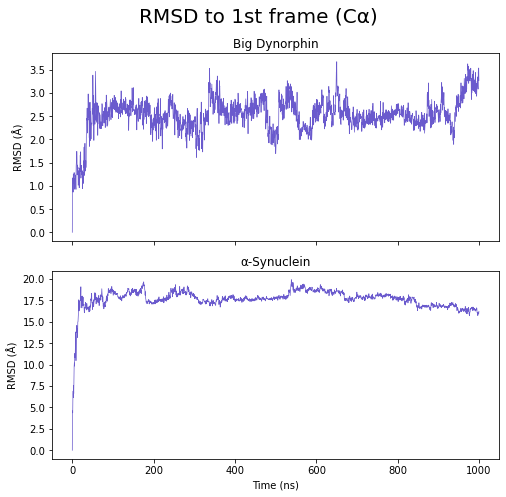

In [5]:
#Plotting results
fig, axs = plt.subplots(2, sharex=True, figsize=(7,7), facecolor='white')
fig.suptitle("RMSD to 1st frame (Cα)", fontsize=20)
axs[0].plot([length*a/len(peptide_rmsd) for a in range(len(peptide_rmsd))],peptide_rmsd,
            color=pt_col, linewidth=0.7)
axs[0].set_title('Big Dynorphin')
axs[1].plot([length*a/len(synuclein_rmsd) for a in range (len(peptide_rmsd))], synuclein_rmsd, 
            color=pt_col, linewidth=0.7)
axs[1].set_title('α-Synuclein')
axs[1].set(xlabel='Time (ns)')
for ax in axs.flat:
    ax.set(ylabel='RMSD (Å)')
fig.tight_layout()
plt.savefig('./plots/rmsd_1st_frame.png', bbox_inches='tight')
plt.show()

## All-to-All RMSD ##

In [6]:
#Calculating ATA
peptide_ata = pt.pairwise_rmsd(traj=trajectory, mask=':1-32@CA')
synuclein_ata = pt.pairwise_rmsd(traj=trajectory, mask=':33-172@CA')

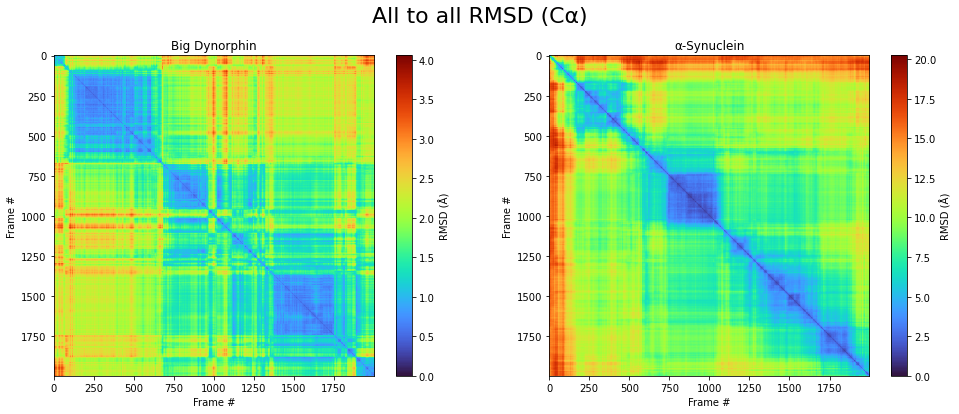

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.83), facecolor='white')
fig.suptitle('All to all RMSD (Cα)', fontsize=22)

p0 = axs[0].imshow(peptide_ata, cmap='turbo', vmin=0.0)
axs[0].set_title('Big Dynorphin')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.3)
fig.colorbar(p0, cax=cax, aspect=40).set_label('RMSD (Å)')

p1 = axs[1].imshow(synuclein_ata, cmap='turbo', vmin=0.0)
axs[1].set_title('α-Synuclein')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.3)
fig.colorbar(p1, cax=cax, aspect=40).set_label('RMSD (Å)')

for ax in axs.flat:
    ax.set(xlabel='Frame #', ylabel='Frame #')
fig.tight_layout()
plt.savefig('./plots/ata_rmsd.png', bbox_inches='tight')
plt.show()

## Principal component analysis (PCA) ##

In [8]:
#Compute PCA
peptide_pca = pt.pca(traj=trajectory, mask=':1-32@CA', n_vecs=2)
synuclein_pca = pt.pca(traj=trajectory, mask=':33-172@CA', n_vecs=2)

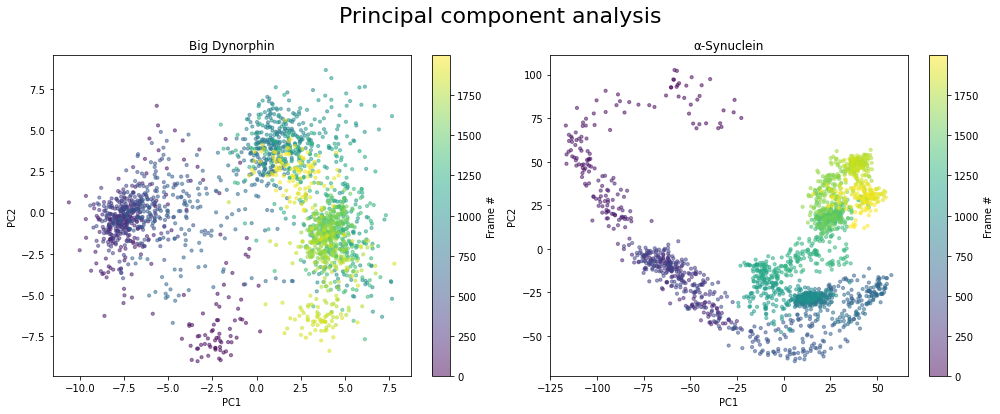

In [9]:
pep_projection_data = peptide_pca[0]
syn_projection_data = synuclein_pca[0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.83), facecolor='white')
fig.suptitle('Principal component analysis', fontsize=22)

p0 = axs[0].scatter(pep_projection_data[0], pep_projection_data[1],
                   c=range(trajectory.n_frames), alpha=0.5, s=10)
axs[0].set_title('Big Dynorphin')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.3)
fig.colorbar(p0, cax=cax, aspect=40).set_label('Frame #')

p1 = axs[1].scatter(syn_projection_data[0], syn_projection_data[1],
                   c=range(trajectory.n_frames), alpha=0.5, s=10)
axs[1].set_title('α-Synuclein')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.3)
fig.colorbar(p1, cax=cax, aspect=40).set_label('Frame #')

for ax in axs.flat:
    ax.set(xlabel='PC1', ylabel='PC2')
fig.tight_layout()
plt.savefig('./plots/pca.png', bbox_inches='tight')
plt.show()

## RMSF ##

In [10]:
#Superimposing Cα to 1st frame
pt.superpose(traj=trajectory, ref=0, mask='@CA')

#Calculating RMSF
peptide_rmsf = pt.rmsf(trajectory, mask=':1-32@CA', options='byres')
synuclein_rmsf = pt.rmsf(trajectory, mask=':33-172@CA', options='byres')

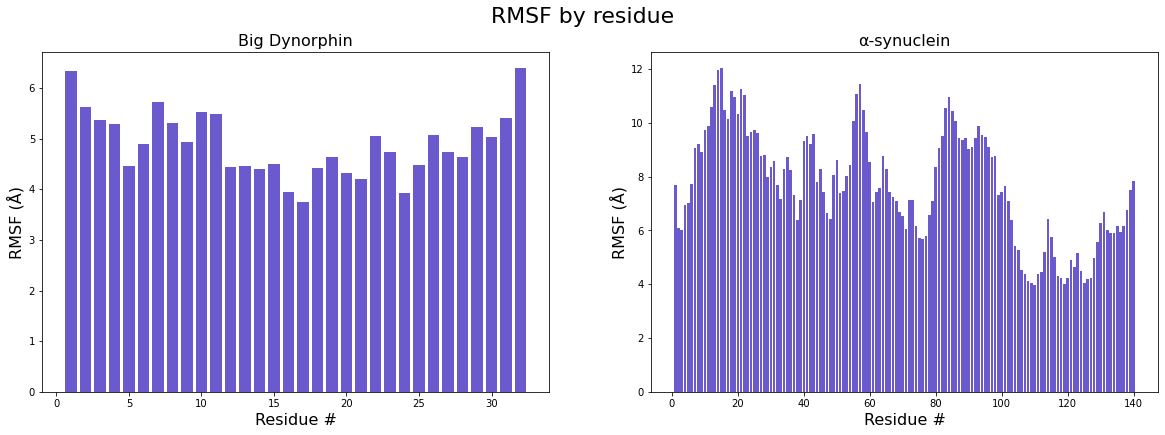

In [11]:
#Plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6.25), facecolor='white')
fig.suptitle('RMSF by residue', fontsize=22)

axs[0].bar(peptide_rmsf.T[0], peptide_rmsf.T[1], color=pt_col)
axs[0].set_title('Big Dynorphin', fontsize=16)

axs[1].bar(range(1,141), synuclein_rmsf.T[1], color=pt_col)
axs[1].set_title('α-synuclein', fontsize=16)

for ax in axs.flat:
    ax.set_xlabel('Residue #', fontsize=16)
    ax.set_ylabel('RMSF (Å)', fontsize=16)
plt.savefig('./plots/rmsf.png', bbox_inches='tight')
plt.show()

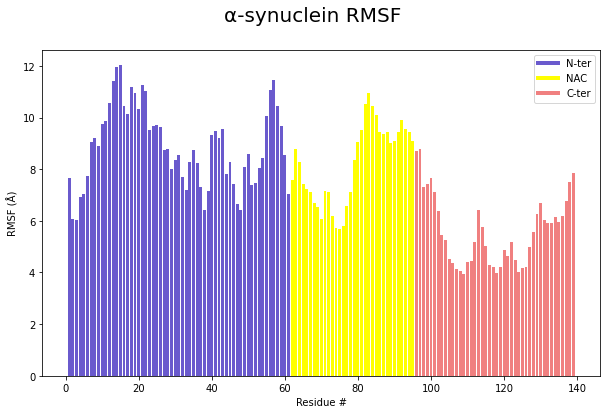

In [12]:
#Creating lines for legend
legend_regions = [Line2D([0], [0], color='slateblue', lw=4),
                 Line2D([0], [0], color='yellow', lw=4),
                 Line2D([0], [0], color='lightcoral', lw=4)]

#Plot RMSF of synuclein with different colorings by region
plt.figure(figsize=(10,6), facecolor='white')
plt.bar(range(1,63), synuclein_rmsf.T[1][0:62], color='slateblue')
plt.bar(range(62,96), synuclein_rmsf.T[1][62:96], color='yellow')
plt.bar(range(96,140), synuclein_rmsf.T[1][96:], color='lightcoral')
plt.suptitle('α-synuclein RMSF', fontsize=20)
plt.xlabel('Residue #')
plt.ylabel('RMSF (Å)')
plt.legend(legend_regions, ['N-ter', 'NAC', 'C-ter'])
plt.savefig('./plots/asyn_rmsf.png', bbox_inches='tight')
plt.show()

## Radius of gyration ##

In [13]:
#Compute radius of gyration
peptide_rg = pt.radgyr(traj=trajectory, mask=':1-32@CA')
synuclein_rg = pt.radgyr(traj=trajectory, mask=':33-172@CA')

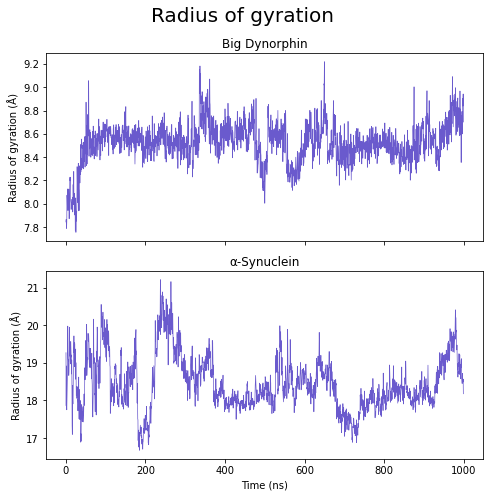

In [14]:
#Plotting results
fig, axs = plt.subplots(2, sharex=True, figsize=(7,7), facecolor='white')
fig.suptitle("Radius of gyration", fontsize=20)
axs[0].plot([length*a/len(peptide_rg) for a in range(len(peptide_rg))],peptide_rg,
            color=pt_col, linewidth=0.7)
axs[0].set_title('Big Dynorphin')
axs[1].plot([length*a/len(synuclein_rg) for a in range (len(peptide_rg))], synuclein_rg, 
            color=pt_col, linewidth=0.7)
axs[1].set_title('α-Synuclein')
axs[1].set(xlabel='Time (ns)')
for ax in axs.flat:
    ax.set(ylabel='Radius of gyration (Å)', )
fig.tight_layout()
plt.savefig('./plots/radius_of_gyration.png', bbox_inches='tight')
plt.show()